In [1]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/energy-based-models-compression.git
    %cd energy-based-models-compression/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [2]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import torch.nn.utils.prune as prune
from torch.nn import functional as F


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Pytorch Summary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install --quiet torchsummary
    from torchsummary import summary

import numpy as np
import pandas as pd
import json
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from metrics.classifier import VGG
from metrics.scores import frechet_inception_distance, inception_score
from EBM import DeepEnergyModel
from energy_funcs.cnn import CNNModel
from sampler import Sampler
from callbacks import InceptionScoreCallback, \
    FIDCallback, SamplerCallback, OutlierCallback, \
    GenerateImagesCallback

import shutil
if IN_COLAB:
    from google.colab import files, drive
    drive.mount('/content/drive')

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"
DRIVE_PATH = "/content/drive/My Drive/EBM_saved_models/"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

pl.seed_everything(43)

/var/folders/pl/gjvtfzbj4691nr_0pszjdspw0000gn/T/ipykernel_29422/3909588978.py:38: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 43


Device: cpu
Device:  cpu


43

In [4]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=2)

In [5]:
if os.path.exists('../saved_models/mnist-classifier-1 (1).pth'):
    # Load the best model
    mnist_classifier = VGG()

    if device == 'cuda':
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth'))
    else:
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth', map_location=torch.device('cpu')))

    mnist_classifier.to(device)
    print("Model already exists and loaded.")
    summary(mnist_classifier, input_size=(1, 28, 28))
else:
    print("Classifier not found in saved_models. Please run the classifier notebook first.")

Model already exists and loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
      

In [6]:
@torch.no_grad()
def calculate_fid(real_imgs, fake_imgs, mnist_classifier):
    # Function to calculate the FID score

    def extract_features(images, model):
        # Function to extract features from images using the provided model
        model.eval()
        # with torch.no_grad():
        features = model.get_activations(images)
        return features.cpu().numpy()

    # Extract features from real and fake images
    real_features = extract_features(real_imgs, mnist_classifier)
    fake_features = extract_features(fake_imgs, mnist_classifier)

    fid_score = frechet_inception_distance(real_features, fake_features)
    
    return fid_score

In [7]:
@torch.no_grad()
def calculate_inception(fake_imgs, mnist_classifier):
    # Function to calculate the IS score
    mnist_classifier.eval()
    # with torch.no_grad():
    log_p_yx = mnist_classifier(fake_imgs)
    p_yx = torch.exp(log_p_yx).cpu().numpy()
    score = inception_score(p_yx)

    return score

In [8]:
@torch.no_grad()
def calculate_ood_detection(model, rand=True):
    # Function to calculate out-of-distribution detection score
    # rand=True: random samples 
    # rand=False: samples from the training set
    model.eval()
    if rand:
        rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
        rand_imgs = rand_imgs * 2 - 1.0
        rand_out = model.cnn(rand_imgs).mean()
        print(f"Average score for random images: {rand_out.item():4.2f}")
        return rand_out.item()

    else:
        train_imgs,_ = next(iter(train_loader))
        train_imgs = train_imgs.to(model.device)
        train_out = model.cnn(train_imgs).mean()
        print(f"Average score for training images: {train_out.item():4.2f}")
        return train_out.item()

In [49]:
@torch.no_grad()
def compare_images(img1, img2, model):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    score1, score2 = score1.mean(), score2.mean()
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    # img1 = (img1 + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    # img2 = (img2 + 1) / 2
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    # grid = grid.permute(1, 2, 0)
    # plt.figure(figsize=(4,4))
    # plt.imshow(grid)
    # plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
    #            labels=["Original image", "Transformed image"])
    # plt.yticks([])
    # plt.show()
    # print(f"Score original image: {score1.item():4.2f}")
    # print(f"Score transformed image: {score2.item():4.2f}")
    return [score1, score2]

In [96]:
def transform_image(transformation, i, model):
    test_imgs, _ = next(iter(test_loader))
    exmp_img = test_imgs[i].to(model.device)
    transformed_img = None
    if transformation == "noise":
        transformed_img = exmp_img + torch.randn_like(exmp_img) * 1.0
        transformed_img.clamp_(min=-1.0, max=1.0)
    elif transformation == "flip":
        transformed_img = exmp_img.flip(dims=(1,2))
    elif transformation == "tiny":
        transformed_img = torch.zeros_like(exmp_img)-1
        transformed_img[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
    
    return exmp_img, transformed_img

In [97]:
def get_images(model, train=False):
    data_loader = train_loader if train else test_loader
    real_imgs = None
    for imgs, _ in data_loader:
        real_imgs = imgs.cpu() # Move to CPU 
        break  # Only one batch is needed
    
    batch_size = real_imgs.shape[0]
    callback = GenerateImagesCallback(batch_size=batch_size, vis_steps=8, num_steps=1)
    fake_imgs = callback.generate_imgs(model)
    fake_imgs = fake_imgs.squeeze(0).cpu()

    return real_imgs, fake_imgs

In [12]:

if IN_COLAB:
    pretrained_filename = os.path.join(DRIVE_PATH, "MNIST_resnet18.ckpt")
else:
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST_resnet18.ckpt")

teacher_model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
summary(teacher_model, input_size=(1, 28, 28))
# pl.seed_everything(43)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
             Swish-2           [-1, 64, 14, 14]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
             Swish-5             [-1, 64, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]          36,928
             Swish-7             [-1, 64, 7, 7]               0
BasicResidualBlock-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
            Swish-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
            Swish-12             [-1, 64, 7, 7]               0
BasicResidualBlock-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 1

In [106]:
real_imgs, fake_imgs = get_images(teacher_model)
teacher_fid = calculate_fid(real_imgs, fake_imgs, mnist_classifier)
teacher_is = calculate_inception(fake_imgs, mnist_classifier)
teacher_ood = calculate_ood_detection(teacher_model, rand=False)

Average score for training images: 0.00


In [108]:
print(f"Teacher FID: {teacher_fid:4.2f}")
print(f"Teacher IS: {teacher_is:4.2f}")
print(f"Teacher OOD: {teacher_ood:4.2f}")

Teacher FID: 5276.16
Teacher IS: 1.14
Teacher OOD: 0.00


## Students

In [13]:
class DistilledDeepEnergyModel(DeepEnergyModel):
    def __init__(self, img_shape, batch_size, soft_loss_weight, hard_loss_weight, 
                f=CNNModel, **f_args):
        super().__init__(img_shape=img_shape, batch_size=batch_size, f=f, **f_args)
        self.teacher_energy = nn.Linear(10, 1).to(device)
        self.soft_loss_weight = soft_loss_weight
        self.hard_loss_weight = hard_loss_weight
        self.cnn = f(**f_args).to(device)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)

    # def set_teacher_model(self, teacher_model):
    #     self.teacher_model = teacher_model
    #     self.teacher_model.eval()

    def get_mse_loss(self, student_output, teacher_output):
        loss = F.mse_loss(student_output, teacher_output)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = super().training_step(batch, batch_idx)

        real_imgs, _ = batch
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        student_energy = self.cnn(inp_imgs)
        with torch.no_grad():
            teacher_energy = self.teacher_energy(teacher_model(inp_imgs)).squeeze()

        # Calculate mse loss and add it to the original loss
        mse_loss = self.get_mse_loss(student_energy, teacher_energy)
        total_loss = self.hard_loss_weight*loss + self.soft_loss_weight*mse_loss

        # Logging
        self.log('distillation_loss', mse_loss)
        self.log('total_loss', total_loss)

        return total_loss

    def validation_step(self, batch, batch_idx):
        loss = super().training_step(batch, batch_idx)

        real_imgs, _ = batch
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        student_energy = self.cnn(inp_imgs)
        with torch.no_grad():
            teacher_energy = self.teacher_energy(teacher_model(inp_imgs))

        # Calculate mse loss and add it to the original loss
        mse_loss = self.get_mse_loss(student_energy, teacher_energy)
        total_loss = self.hard_loss_weight*loss + self.soft_loss_weight*mse_loss

        self.log('val_distillation_loss', mse_loss)
        self.log('val_total_loss', total_loss)
        return mse_loss

In [163]:
def student_scores(students, train=False):
    fid_scores = []
    is_scores = []
    ood_scores = []

    for student in students:
        real_imgs, fake_imgs = get_images(student, train=train)
        fid_scores.append(-calculate_fid(real_imgs, fake_imgs, mnist_classifier))
        is_scores.append(calculate_inception(fake_imgs, mnist_classifier))
        ood_scores.append(calculate_ood_detection(student, rand=False))

        # for transormation in ["noise", "flip", "tiny"]:
        #     for i in [-1, 9, 6]:
        #         exmp_img, transformed_img = transform_image(transormation, i, student)
        #         if transormation == "noise":
        #             ood_noise_scores.append(compare_images(exmp_img, transformed_img, student)[1])
        #         elif transormation == "flip":
        #             ood_flip_scores.append(compare_images(exmp_img, transformed_img, student)[1])
        #         else:
        #             ood_tiny_scores.append(compare_images(exmp_img, transformed_img, student)[1])    
    
    return fid_scores, is_scores, ood_scores


In [159]:
def transformation_scores(students):
    ood_noise_scores = []
    ood_tiny_scores = []
    ood_flip_scores = []

    for transformation in ["noise", "flip", "tiny"]:
        for i in [-1, 9, 6]:
            for student in students:
                exmp_img, transformed_img = transform_image(transformation, i, student)
                if transformation == "noise":
                    ood_noise_scores.append(compare_images(exmp_img, transformed_img, student)[1])
                elif transformation == "flip":
                    ood_flip_scores.append(compare_images(exmp_img, transformed_img, student)[1])
                else:
                    ood_tiny_scores.append(compare_images(exmp_img, transformed_img, student)[1])

    return ood_tiny_scores, ood_flip_scores, ood_noise_scores

In [176]:
students = []

# Load models
for i in range(1, 7):
    student_filename = os.path.join(CHECKPOINT_PATH, f"MNIST/student/MNIST_resnet_student_{i}.ckpt")
    student_model = DistilledDeepEnergyModel.load_from_checkpoint(student_filename)
    students.append(student_model)

# Function to count the parameters of a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Add a 'num_parameters' attribute to each model
for student in students:
    student.num_parameters = count_parameters(student)

# Now sort the students list by the 'num_parameters' attribute
students_sorted_by_size = sorted(students, key=lambda x: x.num_parameters)

# The 'students_sorted_by_size' now holds models ordered by size
for student in students_sorted_by_size:
    print(f"Student {student.cnn.__class__.__name__}, with {student.num_parameters} parameters")

Student SimpleCNNModel_1, with 2412 parameters
Student SimpleCNNModel_2, with 19436 parameters
Student SimpleCNNModel_3, with 43452 parameters
Student CNNModel, with 77004 parameters
Student ResNetModel, with 270725 parameters
Student ResNet18Simpler, with 2795925 parameters


In [177]:
for student in students:
    print(f"Student {student.cnn.__class__.__name__}, with {student.num_parameters} parameters")

Student CNNModel, with 77004 parameters
Student ResNetModel, with 270725 parameters
Student SimpleCNNModel_1, with 2412 parameters
Student SimpleCNNModel_3, with 43452 parameters
Student SimpleCNNModel_2, with 19436 parameters
Student ResNet18Simpler, with 2795925 parameters


In [164]:
students_fid, students_is, students_ood = student_scores(students_sorted_by_size, train=False)

Average score for training images: -0.00
Average score for training images: 0.00
Average score for training images: 0.00
Average score for training images: -0.02
Average score for training images: 0.00
Average score for training images: 0.00


In [165]:
students_ood_tiny, students_ood_flip, students_ood_noise = transformation_scores(students_sorted_by_size)

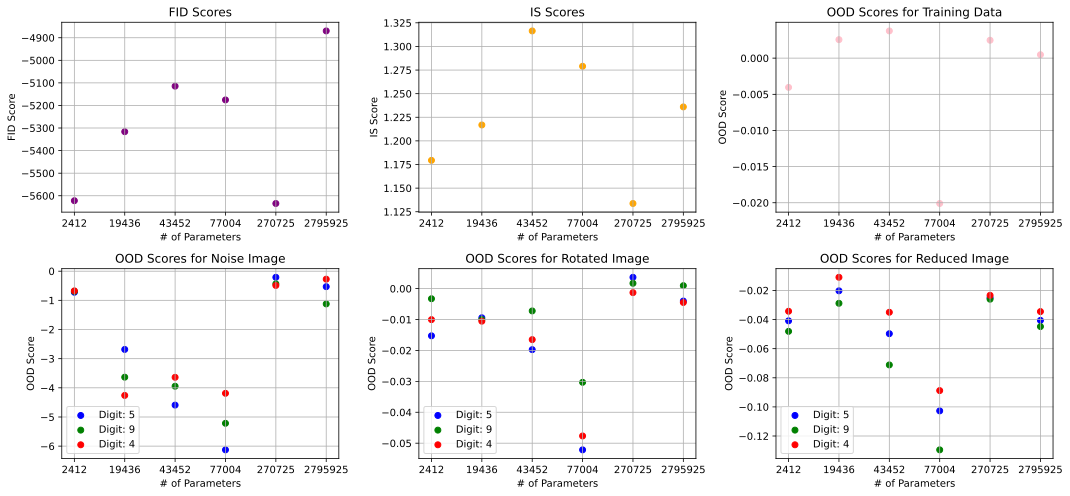

In [166]:
# Model identifiers
num_parameters = [str(student.num_parameters) for student in students_sorted_by_size]

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# FID Scores Plot
axs[0, 0].scatter(num_parameters, students_fid, color='purple')
axs[0, 0].set_title('FID Scores')
axs[0, 0].set_xlabel('# of Parameters')
axs[0, 0].set_ylabel('FID Score')
axs[0, 0].grid(True)

# ID Scores Plot
axs[0, 1].scatter(num_parameters, students_is, color='orange')
axs[0, 1].set_title('IS Scores')
axs[0,1].set_xlabel('# of Parameters')
axs[0, 1].set_ylabel('IS Score')
axs[0, 1].grid(True)

# ID Scores Plot
axs[0, 2].scatter(num_parameters, students_ood, color='pink')
axs[0, 2].set_title('OOD Scores for Training Data')
axs[0, 2].set_xlabel('# of Parameters')
axs[0, 2].set_ylabel('OOD Score')
axs[0, 2].grid(True)

axs[1, 0].scatter(num_parameters, students_ood_noise[:6], color='blue', label='Digit: 5')
axs[1, 0].scatter(num_parameters, students_ood_noise[6:12], color='green', label='Digit: 9')
axs[1, 0].scatter(num_parameters, students_ood_noise[12:], color='red', label='Digit: 4')
axs[1, 0].set_title('OOD Scores for Noise Image')
axs[1, 0].set_xlabel('# of Parameters')
axs[1, 0].set_ylabel('OOD Score')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].scatter(num_parameters, students_ood_flip[:6], color='blue', label='Digit: 5')
axs[1, 1].scatter(num_parameters, students_ood_flip[6:12], color='green', label='Digit: 9')
axs[1, 1].scatter(num_parameters, students_ood_flip[12:], color='red', label='Digit: 4')
axs[1, 1].set_title('OOD Scores for Rotated Image')
axs[1, 1].set_xlabel('# of Parameters')
axs[1, 1].set_ylabel('OOD Score')
axs[1, 1].grid(True)
axs[1, 1].legend()

axs[1, 2].scatter(num_parameters, students_ood_tiny[:6], color='blue', label='Digit: 5')
axs[1, 2].scatter(num_parameters, students_ood_tiny[6:12], color='green', label='Digit: 9')
axs[1, 2].scatter(num_parameters, students_ood_tiny[12:], color='red', label='Digit: 4')
axs[1, 2].set_title('OOD Scores for Reduced Image')
axs[1, 2].set_xlabel('# of Parameters')
axs[1, 2].set_ylabel('OOD Score')
axs[1, 2].grid(True)
axs[1, 2].legend()

# Adjust the layout
plt.tight_layout()
# Display the plot
plt.show()

In [169]:

@torch.no_grad()
def compare_images_plots(img1, img2, model):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model(imgs).cpu().chunk(2, dim=0)

    score1, score2 = score1.mean(), score2.mean()
    print(score1, score2)
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    # Normalize the images
    img1 = (img1 + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    img2 = (img2 + 1) / 2
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1}")
    print(f"Score transformed image: {score2}")


tensor(-0.0077) tensor(-0.0033)


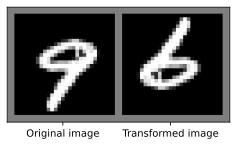

Score original image: -0.007733719423413277
Score transformed image: -0.003270970657467842
tensor(0.0159) tensor(-0.0100)


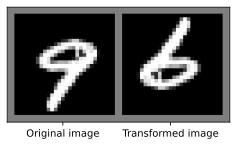

Score original image: 0.015924029052257538
Score transformed image: -0.010009847581386566
tensor(0.0123) tensor(-0.0072)


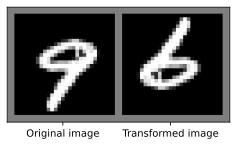

Score original image: 0.012280195951461792
Score transformed image: -0.007213085889816284
tensor(-0.0016) tensor(-0.0303)


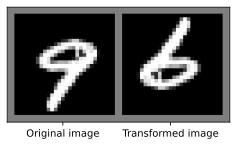

Score original image: -0.0015590712428092957
Score transformed image: -0.030300810933113098
tensor(0.0058) tensor(0.0017)


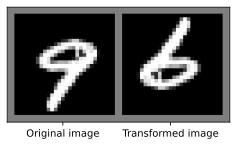

Score original image: 0.005811705254018307
Score transformed image: 0.001723287277854979
tensor(0.0030) tensor(0.0010)


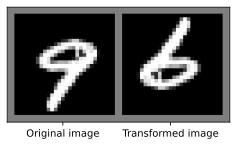

Score original image: 0.0030313306488096714
Score transformed image: 0.0009581822087056935


In [171]:
exmp_img, trans_image = transform_image("flip", 9, students_sorted_by_size[0])
compare_images_plots(exmp_img, trans_image, students_sorted_by_size[0])
compare_images_plots(exmp_img, trans_image, students_sorted_by_size[1])
compare_images_plots(exmp_img, trans_image, students_sorted_by_size[2])
compare_images_plots(exmp_img, trans_image, students_sorted_by_size[3])
compare_images_plots(exmp_img, trans_image, students_sorted_by_size[4])
compare_images_plots(exmp_img, trans_image, students_sorted_by_size[5])

Seed set to 43


Student CNN:  SimpleCNNModel_1
Student CNN:  SimpleCNNModel_2
Student CNN:  SimpleCNNModel_3
Student CNN:  CNNModel
Student CNN:  ResNetModel
Student CNN:  ResNet18Simpler


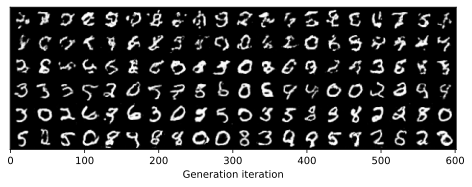

In [149]:
import random

callback = GenerateImagesCallback(batch_size=1, vis_steps=8, num_steps=256)
pl.seed_everything(43)

all_grids = []

for student in students_sorted_by_size:
    print("Student CNN: ", student.cnn.__class__.__name__)
    exmp_imgs = []
    for _ in range(34):
        imgs_per_step = callback.generate_imgs(student)
        imgs_per_step = imgs_per_step.cpu()
        exmp_imgs.append(imgs_per_step[-1])

    imgs_to_plot = random.sample(exmp_imgs, 20)
    imgs_to_plot = torch.cat(imgs_to_plot, dim=0)
    imgs_to_plot = (imgs_to_plot + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=20, normalize=True)
    grid = grid.permute(1, 2, 0)
    all_grids.append(grid)
# plt.figure(figsize=(8,8))
# plt.imshow(grid)
# plt.xlabel("Generation iteration")
# # plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
# #         labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
# plt.yticks([])
# plt.show()
    
# Concatenate all grids along a new dimension to create a final grid
final_grid = torch.cat(all_grids, dim=0)  # Concatenate along the vertical axis

# Display the final grid
plt.figure(figsize=(8, len(students) * 8))  # Adjust the figure size as needed
plt.imshow(final_grid)
plt.xlabel("Generation iteration")
plt.yticks([])
plt.show()

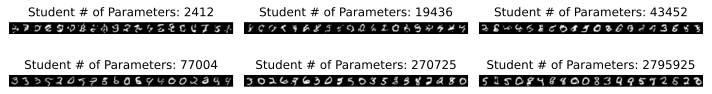

In [153]:
ig, axs = plt.subplots(2, 3, figsize=(10, 2))

for idx, grid in enumerate(all_grids):
    # Calculate row and column for the current subplot
    row = idx // 3
    col = idx % 3

    # Plot each grid in its subplot
    ax = axs[row, col]
    ax.imshow(grid)
    ax.set_title(f"Student # of Parameters: {students_sorted_by_size[idx].num_parameters}")
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

Seed set to 43


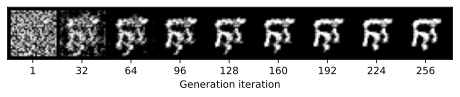

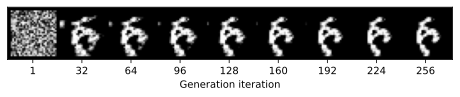

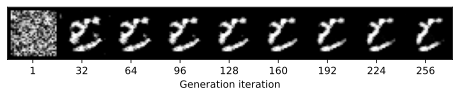

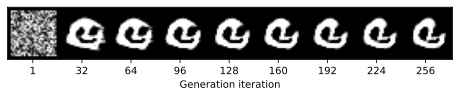

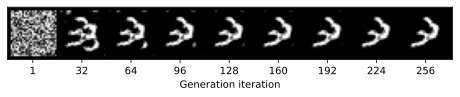

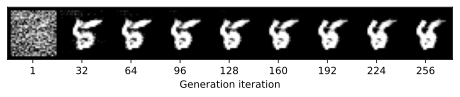

In [113]:
callback = GenerateImagesCallback(batch_size=4, vis_steps=8, num_steps=256)
pl.seed_everything(43)

for student in students_sorted_by_size:
    imgs_per_step = callback.generate_imgs(student)
    imgs_per_step = imgs_per_step.cpu()

    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,1]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,1],imgs_to_plot], dim=0)

    # Normalize the images
    imgs_to_plot = (imgs_to_plot + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True)
                
    # grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
            labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

In [180]:
real_imgs, fake_imgs = get_images(teacher_model, train=False)
fid_score = -calculate_fid(real_imgs, fake_imgs, mnist_classifier)
is_score = calculate_inception(fake_imgs, mnist_classifier)
ood_score = calculate_ood_detection(teacher_model, rand=False)

Average score for training images: 0.00


In [181]:
print(f"Teacher FID: {fid_score:4.2f}")
print(f"Teacher IS: {is_score:4.2f}")
print(f"Teacher OOD: {ood_score:4.2f}")

Teacher FID: -5275.55
Teacher IS: 1.13
Teacher OOD: 0.00
